# Problem 2 Solution

Use this notebook to write your code for problem 2. You may reuse your SGD code from last week.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datafile = open("../data/wine_training1.txt")
DELIM = ","

In [3]:
def loss(w, x, y):
    """ 
    Calculates mean log loss of the linear model represented
    by w given a matrix of training points x (individual rows correspond to
    training points) with corresponding labels y.
    """
    loss = 0.0
    for i in range(len(x)):
        loss += np.log(1 + np.exp(-y[i] * np.dot(w, x[i])))
    return loss / len(x)

def update(w, eta, xi, yi, lmbda):
    """
    Given a d-dimensional training point xi with label yi (yi = 1 or -1) and d-dimensional weight 
    vector w, updates w using the gradient of the log loss evaluated on xi, learning rate eta,
    and regularization term lmbda.
    """
    # orig_update = (-yi * xi) / (1 + np.exp(yi * np.dot(w, xi))) + 2 * lmbda * w
    # grad_update is equivalent to orig_update except the numerator & denominator have
    # been multiplied by exp_term; this slightly helps reduce overflow issues
    exp_term = np.exp(-0.5 * yi * np.dot(w, xi))
    grad_update = (-yi * xi * exp_term) / (exp_term + np.exp(0.5 * yi * np.dot(w, xi))) + 2 * lmbda * w
    w -= eta * grad_update

# Updates w by epoch using the update function.
def epoch_update(w, x, y, eta, lmbda, order):
    """
    Runs a single epoch of SGD, updating w on the training points in the
    matrix x with corresponding labels y. Uses a learning rate of eta and regularization
    term lambda = lmbda. Iterates through the rows of x (x[i] = training point i) in
    the order specified by <order> (shuffled list of indices of training points)
    """
    ## NOTE: We divide lambda by the number of points in our training set
    normalized_lambda = lmbda / len(x)
    for train_pt_idx in order:
        update(w, eta, x[train_pt_idx], y[train_pt_idx], normalized_lambda)

def read_data(filename):
    """
    Reads data from the passed-in file, returning a pair of matrices (x, y)
    where each row x[i] is a d-dimensional training point with corresponding 
    label y[i].
    """
    x = []
    y = []
    with open(filename, 'r') as datafile:
        # Skip header line
        datafile.readline()
        for line in datafile:
            line = line.strip().split(DELIM)
            # The first column of each row is the label y
            y.append(float(line[0]))
            # The remaining columns (1 through NDIMS) are the elements of the current
            # training point. We prepend a 1 to each training point to account for the
            # bias term
            x.append([1] + [float(line[i]) for i in range(1, NDIMS + 1)])
    x = np.asarray(x)
    y = np.asarray(y)
    return (x, y)

def SGD(w, x, y, eta, lmbda, n_epochs=0):
    """
    Update w in-place by running SGD for n_epochs epochs.
     """
    print("Running SGD for up to %s epochs. eta = %f, lambda = %f"%(n_epochs, eta, lmbda))
    # Build up an array of losses per epoch
    losses = np.array([loss(w, x, y)])

    for i in range(n_epochs):
        order = np.random.permutation(len(x))
        epoch_update(w, x, y, eta, lmbda, order)
        losses = np.append(losses, loss(w, x, y))
        if (i + 1) % 2000 == 0:
            print("Finished epoch %s, Ein: %s"%(i + 1, losses[i]))

    return w, losses

def standardize(x):
    """ Standardizes each column of the matrix x to have 0 mean and unit variance. """
    numcols = len(x[0])
    means = [x[:, idx].mean() for idx in range(numcols)]
    stdevs = [np.std(x[:, idx]) for idx in range(numcols)]
    return standardize_helper(x, means, stdevs)

def standardize_helper(matrix, means, stdevs):
    """ Helper function for standardizing <matrix>. """
    numcols = len(matrix[0])    
    for idx in range(numcols):
        # Don't standardize the bias column
        if stdevs[idx] == 0:
            continue
        # Update column idx of the matrix by subtracting means[idx] from each
        # entry and dividing by stdevs[idx]
        matrix[:, idx] = (matrix[:, idx] - means[idx]) / stdevs[idx]
    return means, stdevs

In [4]:
# NDIMS = Size of a single training point, excluding the constant 1 
# prepended to each training point to represent a bias term
NDIMS = len(datafile.readline().strip().split(DELIM)) - 1
LEARNING_RATE = 5e-4
NUM_EPOCHS = 20000

# Read in training data
x1, y1 = read_data("../data/wine_training1.txt")
x2, y2 = read_data("../data/wine_training2.txt")

x_train = [x1, x2]
y_train = [y1, y2]  

# To store Ein and Eout:
Ein_all = []
Eout_all = []

# To store weight vectors:
w_all = []

In [5]:
# Lambda values to use:
NUM_LAMBDAS = 15
lambda_vals = [1e-5 * (5 ** i) for i in range(NUM_LAMBDAS)]

for j in range(len(x_train)): # Loop over training sets 1 and 2

    # Extract training data:
    x = x_train[j]
    y = y_train[j]

    # Normalize training data, recover mean & stdev of test data cols
    means, stdevs = standardize(x)

    # Read in test data
    xtest, ytest = read_data("../data/wine_testing.txt")

    # Normalize test data using means/stdevs from training data
    standardize_helper(xtest, means, stdevs)

    # Compute Ein, Eout, and w for each value of lambda
    Ein = []
    Eout = []
    w_vec = np.empty((len(lambda_vals), x.shape[1]))

    for i in range(len(lambda_vals)):
        w_init = 0.01 * np.random.uniform(size=[NDIMS + 1])

        w, losses = SGD(w_init, x, y, eta=LEARNING_RATE, lmbda=lambda_vals[i], n_epochs=NUM_EPOCHS)
        eout = loss(w, xtest, ytest)        
        print("Mean weight for lambda = %s: %s, took %s epochs"%(lambda_vals[i], w.mean(), len(losses)))
        print("Eout: %s"%eout)
        Eout.append(eout) 
        Ein.append(losses[-1])
        w_vec[i, :] = w

    Ein_all.append(Ein)
    Eout_all.append(Eout)
    w_all.append(w_vec)

Running SGD for up to 20000 epochs. eta = 0.000500, lambda = 0.000010
Finished epoch 2000, Ein: 0.01522291483032575
Finished epoch 4000, Ein: 0.008648812538803006
Finished epoch 6000, Ein: 0.0061554911177882764
Finished epoch 8000, Ein: 0.004813793691490947
Finished epoch 10000, Ein: 0.003967496061879156
Finished epoch 12000, Ein: 0.0033819915510932934
Finished epoch 14000, Ein: 0.002951487450307213
Finished epoch 16000, Ein: 0.0026209483124560616
Finished epoch 18000, Ein: 0.002358798615825973
Finished epoch 20000, Ein: 0.0021455768767066822
Mean weight for lambda = 1e-05: -0.7548433077668335, took 20001 epochs
Eout: 0.12946583672827536
Running SGD for up to 20000 epochs. eta = 0.000500, lambda = 0.000050
Finished epoch 2000, Ein: 0.015225095437411327
Finished epoch 4000, Ein: 0.00865058393065925
Finished epoch 6000, Ein: 0.006157496697448401
Finished epoch 8000, Ein: 0.004816057069133589
Finished epoch 10000, Ein: 0.003969987502982424
Finished epoch 12000, Ein: 0.003384680157760502
F

Finished epoch 20000, Ein: 0.6755215211627033
Mean weight for lambda = 2441.40625: -0.0028300612614413113, took 20001 epochs
Eout: 0.6763320691979108
Running SGD for up to 20000 epochs. eta = 0.000500, lambda = 12207.031250
Finished epoch 2000, Ein: 0.690341085297254
Finished epoch 4000, Ein: 0.6893436144353126
Finished epoch 6000, Ein: 0.6887948932184272
Finished epoch 8000, Ein: 0.6896644231771696
Finished epoch 10000, Ein: 0.689504834656837
Finished epoch 12000, Ein: 0.6892310360069817
Finished epoch 14000, Ein: 0.6888556994178772
Finished epoch 16000, Ein: 0.689028301870875
Finished epoch 18000, Ein: 0.6895056540739536
Finished epoch 20000, Ein: 0.6894717970555011
Mean weight for lambda = 12207.031250000002: -0.0006289847973734241, took 20001 epochs
Eout: 0.6884000966164178
Running SGD for up to 20000 epochs. eta = 0.000500, lambda = 61035.156250
Finished epoch 2000, Ein: 0.6927085164336259
Finished epoch 4000, Ein: 0.6928401771399859
Finished epoch 6000, Ein: 0.6926463149461263
Fi

Finished epoch 14000, Ein: 0.531951480245505
Finished epoch 16000, Ein: 0.5319353776324706
Finished epoch 18000, Ein: 0.5318671372296551
Finished epoch 20000, Ein: 0.5318615842569273
Mean weight for lambda = 97.65625000000001: -0.021381979306291272, took 20001 epochs
Eout: 0.5862597878485843
Running SGD for up to 20000 epochs. eta = 0.000500, lambda = 488.281250
Finished epoch 2000, Ein: 0.6511982934580136
Finished epoch 4000, Ein: 0.6512622965833257
Finished epoch 6000, Ein: 0.6512070223875527
Finished epoch 8000, Ein: 0.6516244975011487
Finished epoch 10000, Ein: 0.6513109750902787
Finished epoch 12000, Ein: 0.6513172357381265
Finished epoch 14000, Ein: 0.6516083553070414
Finished epoch 16000, Ein: 0.6512385493385924
Finished epoch 18000, Ein: 0.651109371911439
Finished epoch 20000, Ein: 0.6514497941268279
Mean weight for lambda = 488.28125000000006: -0.005203333826149715, took 20001 epochs
Eout: 0.6653022768487786
Running SGD for up to 20000 epochs. eta = 0.000500, lambda = 2441.406

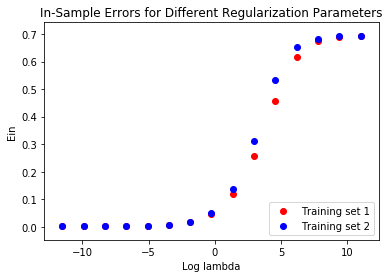

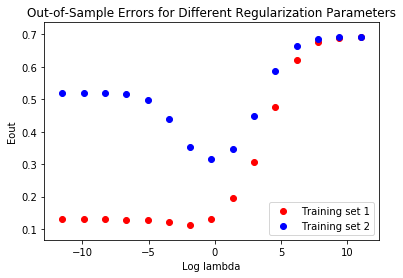

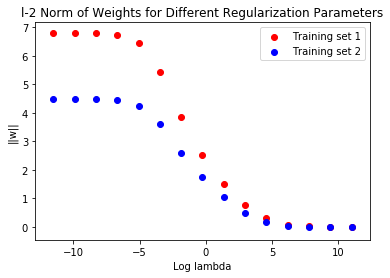

In [6]:
# Plot Ein vs log lambda
plt.figure()
plt.scatter(np.log(lambda_vals), Ein_all[0], color='red')
plt.scatter(np.log(lambda_vals), Ein_all[1], color='blue')
plt.xlabel("Log lambda")
plt.ylabel("Ein")
plt.legend(['Training set 1', 'Training set 2'], loc='lower right')
plt.title('In-Sample Errors for Different Regularization Parameters')
plt.show()

# Plot Eout vs log lambda
plt.figure()
plt.scatter(np.log(lambda_vals), Eout_all[0], color='red')
plt.scatter(np.log(lambda_vals), Eout_all[1], color='blue')
plt.xlabel("Log lambda")
plt.ylabel("Eout")
plt.legend(['Training set 1', 'Training set 2'], loc='lower right')
plt.title('Out-of-Sample Errors for Different Regularization Parameters')
plt.show()

# Calculate and plot norm of w vs log lambda

plt.figure()
colors = ['red', 'blue']

for i in range(2):
    w_norms = np.empty(len(lambda_vals))
    
    # Calculate vector of norms for each training set:
    for j in range(len(lambda_vals)):
        w_norms[j] = np.linalg.norm(w_all[i][j, :])

    plt.scatter(np.log(lambda_vals), w_norms, color = colors[i])

plt.xlabel("Log lambda")
plt.ylabel("||w||")
plt.legend(['Training set 1', 'Training set 2'], loc='best')
plt.title('l-2 Norm of Weights for Different Regularization Parameters')
plt.show()

In [8]:
# Find regularization parameter values which minimize the validation error:
best_lambda_0 = lambda_vals[np.argmin(Eout_all[0])]
print('Lambda = %f minimizes validation error for training set 1' % best_lambda_0)

best_lambda_1 = lambda_vals[np.argmin(Eout_all[1])]
print('Lambda = %f minimizes validation error for training set 2' % best_lambda_1)

Lambda = 0.156250 minimizes validation error for training set 1
Lambda = 0.781250 minimizes validation error for training set 2
